# Multi-Stage Model | Inference Demo

A demo of model predictions and inference with user interaction and visualization.

Erin Josephine (Josie) Donnelly | ejd2170


## Import libraries


In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
import random
import re
import os

import warnings
warnings.filterwarnings('ignore')

from collections import Counter
from nltk.corpus import stopwords

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler

import yfinance as yf

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LSTM, RNN, Bidirectional, Dense, Embedding, TextVectorization, Flatten, Input, Dropout
from tensorflow.keras.utils import plot_model


2022-12-19 20:14:10.245141: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
date_today = datetime.now().date()
print(f'Last updated {date_today}')


Last updated 2022-12-19


## Define hyperparameters


In [3]:
N_DAYS_IN_TEST = 7
N_STOCK_UNITS = 2     # number of STOCK_UNITS of stock data to load in
STOCK_UNIT = 'mo'     # years = 'y', months = 'mo'
N_SEQ_WEEKS = 4     # number of weeks of stock data that will be included in each example's sequence
N_TIMESTEPS = 3

UNIQUE_URL = True     # ensure each URL appears only once and associated with only one stock
ONE_PER_DAY = False     # consider only one article per stock per day
MIN_STOCK_FREQ = None     # the minimum number of articles associated with a stock for it to be considered; non-zero integer or None (same behavior as 0)

REMOVE_STOPWORDS = True
BALANCE_DATASET = True     # ensure the train and tests sets are both split 50-50% with respect to labels

USE_NEWS_MODEL = True
USE_STOCKS_MODEL = True

NEWS_EMBEDDING_DIM = 128
NEWS_USE_BIDIRECTIONAL = True
NEWS_UNITS = [16]
NEWS_DROPOUT = 0.2

STOCK_UNITS = [32, 64]
STOCK_DROPOUT = 0.1

DENSE_UNITS = [32, 32, 1]

LR = 1e-4

BUFFER_SIZE = 1000
BATCH_SIZE = 32

N_EPOCHS = 15

assert USE_NEWS_MODEL or USE_STOCKS_MODEL, "Please indicate at least one of news or stock model"

# hyperparameters chosen using algorithms later:
# MAX_SEQ_LEN
# VOCAB_SIZE


In [4]:
# set the global seed for relative reproducibility
tf.random.set_seed(3)
# as a tradeoff, we sacrifice full reproducibility to gain back some time efficiency using statements like the one below
# tf.config.experimental.enable_op_determinism()


## Read scraped Yahoo Finance news


In [5]:
# download and filter news data according to hyperparameters
verbose = 0
news_dir = '../data'
news_folders = ['scraped_news_from_api', 'scraped_news_from_html']
date_parser = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').date()
news_df = pd.DataFrame()
for folder in news_folders:
    for news_file in os.listdir(os.path.join(news_dir, folder)):
        if not news_file.endswith('.csv'):
            continue
        tmp_df = pd.read_csv(os.path.join(news_dir, folder, news_file), parse_dates=['publish_date'], date_parser=date_parser)
        if verbose > 0:
            print(f'{news_file}\t({tmp_df.shape[0]})')
        news_df = pd.concat([news_df, tmp_df])
    
news_df = news_df.drop(columns=['scrape_date', 'related_tickers']).sort_values('publish_date').rename(columns={'index': 'stock'})
if UNIQUE_URL:
    news_df = news_df.drop_duplicates(subset=['url'], keep='last').reset_index(drop=True)
else:
    news_df = news_df.drop_duplicates(subset=['stock', 'url'], keep='last').reset_index(drop=True)
    
if MIN_STOCK_FREQ is not None:
    stock_counter = Counter(news_df['stock'])
    keep_stocks = [stock for stock,freq in stock_counter.items() if freq >= MIN_STOCK_FREQ]
    news_df = news_df[news_df['stock'].isin(keep_stocks)].reset_index(drop=True)


print(f'Number of articles: {news_df.shape[0]}')
print(f'Number of stocks: {len(np.unique(news_df["stock"]))}')
print(f'Date range: {min(news_df["publish_date"]).date()} to {max(news_df["publish_date"]).date()}')

# uncomment to experiment with having only one article associated with each stock per day
if ONE_PER_DAY:
    news_df = news_df.drop_duplicates(subset=['stock', 'publish_date'], keep='last').reset_index(drop=True)
    
# save articles published today for future inference
today_news_df = news_df[news_df['publish_date']==pd.Timestamp(date_today)]

news_df


Number of articles: 5487
Number of stocks: 160
Date range: 2022-09-02 to 2022-12-19


,stock,url,news,headlines,raw_publish_date,publish_date
0,SPOT,http://www.finance.yahoo.com/news/legendary-mu...,"Mega-hit song ""Gangnam Style"" by K-pop singer ...","['Yahoo Finance', 'Legendary music producer: ‘...","September 2, 2022, 10:32 AM",2022-09-02
1,HMC,http://www.finance.yahoo.com/news/supply-chain...,Supply chain issues have hampered the auto ind...,"['Yahoo Finance', 'Supply chains still hamperi...","October 6, 2022, 2:46 AM",2022-10-06
2,NIO,http://www.finance.yahoo.com/news/14-best-most...,"In this article, we will discuss the 14 best m...","['Yahoo Finance', '14 Best Most Active Stocks ...","October 12, 2022, 7:41 AM",2022-10-12
3,LUV,http://www.finance.yahoo.com/news/airline-stoc...,Airline stocks are so cheap from a valuation p...,"['Yahoo Finance', 'Airline stocks just need a ...","October 12, 2022, 2:11 PM",2022-10-12
4,FOX,http://www.finance.yahoo.com/news/rupert-murdo...,Rupert Murdoch is reportedly considering a rec...,"['Yahoo Finance', 'Rupert Murdoch considers re...","October 14, 2022, 2:44 PM",2022-10-14
...,...,...,...,...,...,...
5482,ADBE,https://finance.yahoo.com/news/company-news-de...,Shares of Adobe Inc. ADBE surged 3% after the ...,"['Yahoo Finance', 'Company News for Dec 19, 20...","December 19, 2022, 6:24 AM",2022-12-19
5483,BYDDY,https://finance.yahoo.com/news/most-dramatic-s...,(Bloomberg) -- From a little-known manufacturi...,"['Yahoo Finance', 'Most Dramatic Stock Moves o...","December 19, 2022, 7:23 AM",2022-12-19
5484,INTC,https://finance.yahoo.com/news/intels-german-a...,Intel Corp (NASDAQ: INTC) retreated from its i...,"['Yahoo Finance', ""Intel's German Ambitions Hi...","December 19, 2022, 5:03 AM",2022-12-19
5485,AZN,https://finance.yahoo.com/news/astrazeneca-dru...,AstraZeneca Plc (NASDAQ: AZN) announced toplin...,"['Yahoo Finance', 'AstraZeneca Drug Imfinzi Fa...","December 19, 2022, 2:48 AM",2022-12-19


In [6]:
# function to standardize text and remove digits, punctuation, stop words
def std_txt(txt, remove_stopwords=True):
    sw = []
    if remove_stopwords:
        sw = stopwords.words('english')
        
    txt = txt.strip().lower()
    txt = re.sub(r'[^\w\s]', ' ', txt)
    txt = re.sub(f'[0-9]', '', txt)
    txt = [word for word in txt.split() if word not in sw]
    txt = ' '.join(txt)
    
    return txt


In [7]:
# standardize and remove stopwords from all news examples
for i in range(news_df.shape[0]):
    news_df.loc[i,'news'] = std_txt(news_df.loc[i,'news'], remove_stopwords=REMOVE_STOPWORDS)
news_df.head()


,stock,url,news,headlines,raw_publish_date,publish_date
0,SPOT,http://www.finance.yahoo.com/news/legendary-mu...,mega hit song gangnam style k pop singer psy i...,"['Yahoo Finance', 'Legendary music producer: ‘...","September 2, 2022, 10:32 AM",2022-09-02
1,HMC,http://www.finance.yahoo.com/news/supply-chain...,supply chain issues hampered auto industry sin...,"['Yahoo Finance', 'Supply chains still hamperi...","October 6, 2022, 2:46 AM",2022-10-06
2,NIO,http://www.finance.yahoo.com/news/14-best-most...,article discuss best active stocks buy want ex...,"['Yahoo Finance', '14 Best Most Active Stocks ...","October 12, 2022, 7:41 AM",2022-10-12
3,LUV,http://www.finance.yahoo.com/news/airline-stoc...,airline stocks cheap valuation perspective oug...,"['Yahoo Finance', 'Airline stocks just need a ...","October 12, 2022, 2:11 PM",2022-10-12
4,FOX,http://www.finance.yahoo.com/news/rupert-murdo...,rupert murdoch reportedly considering recombin...,"['Yahoo Finance', 'Rupert Murdoch considers re...","October 14, 2022, 2:44 PM",2022-10-14


## Download stock data


In [8]:
stocks = list(np.unique(news_df['stock']))
print(f'Downloading stock data for the past {N_STOCK_UNITS}{STOCK_UNIT}...')
history_df = yf.download(stocks, period=f'{N_STOCK_UNITS}{STOCK_UNIT}')
print(f'Shape: {history_df.shape}')
print(f'First level columns: {", ".join(np.unique([c[0] for c in history_df.columns]))}')
history_df.head()


[*********************100%***********************]  160 of 160 completed
Shape: (42, 960)
First level columns: Adj Close, Close, High, Low, Open, Volume


Adj Close                                                \
                 AAL        AAPL        ACI        ADBE      ADDYY   
Date                                                                 
2022-10-20     13.46  143.152527  20.528292  302.380005  53.939999   
2022-10-21     13.71  147.026108  20.955757  306.369995  51.750000   
2022-10-24     14.10  149.202484  20.667467  316.220001  51.360001   
2022-10-25     14.29  152.087708  20.577997  323.790009  50.099998   
2022-10-26     14.00  149.102661  20.309587  320.480011  50.980000   

                                                                     ...  \
                  AGCO       AJRD        ALK        AMD        AMZN  ...   
Date                                                                 ...   
2022-10-20  110.322495  43.549999  39.880001  57.770000  115.250000  ...   
2022-10-21  115.492767  44.880001  41.009998  58.820000  119.320000  ...   
2022-10-24  115.472809  45.330002  42.580002  58.700001  119.820000  ...   
2022-10-25  118.477150  47.490002  43.410000  61.470001  120.599998  ...   
2022-10-26  119.105972  46.759998  42.860001  59.730000  115.660004  ...   

              Volume                                                         \
                 WMG      WMT     WRBY         X       XOM      XPEV   ZEUS   
Date                                                                          
2022-10-20    743700  4251600  1065200  10323100  17649000  31671400  44400   
2022-10-21    703300  6044900   797600  13706800  22814100  21934400  24800   
2022-10-24  10027200  6268900   798900   8990500  17024200  60411400  18800   
2022-10-25   2518100  5017100   938000   9809200  15719800  33409400  21500   
2022-10-26   1706500  6918100  1086100   9868300  17383800  34677700  32800   

                                             
                 ZM       ^GSPC       ^IXIC  
Date                                         
2022-10-20  4156900  4496620000  4628010000  
2022-10-21  3312100  5078020000  4706440000  
2022-10-24  2731600  4747930000  4808710000  
2022-10-25  2992300  4843120000  5141760000  
2022-10-26  2599700  4817310000  5224440000  

[5 rows x 960 columns]

In [9]:
# standardize by stock (close data only)
close_df = history_df['Close']
ss = StandardScaler()
close_df[close_df.columns] = ss.fit_transform(close_df[close_df.columns])

close_df.head()


,AAL,AAPL,ACI,ADBE,ADDYY,AGCO,AJRD,ALK,AMD,AMZN,...,WMG,WMT,WRBY,X,XOM,XPEV,ZEUS,ZM,^GSPC,^IXIC
Date,,,,,,,,,,,,,,,,,,,,,
2022-10-20,-1.010837,-0.371157,6.144947,-1.464797,-0.932085,-2.443956,-2.459172,-3.041821,-1.588401,2.009305,...,-1.618992,-2.200124,-1.873533,-1.520495,-1.566045,-0.388476,-1.817253,0.430659,-2.382126,-1.287867
2022-10-21,-0.508052,0.349146,0.153540,-1.210848,-1.254864,-1.625290,-2.007402,-2.375503,-1.423953,2.445463,...,-1.661740,-1.681970,-1.540143,-0.839189,-1.005958,-0.273319,-1.443247,0.625418,-1.535854,-0.459031
2022-10-24,0.276293,0.753851,-0.117099,-0.583928,-1.312345,-1.628451,-1.854548,-1.449729,-1.442747,2.499046,...,-1.103167,-1.182937,-1.155464,-0.928055,-0.791210,-0.861228,-1.454247,0.554770,-1.101965,-0.144628
2022-10-25,0.658408,1.290364,-0.201091,-0.102122,-1.498053,-1.152740,-1.120848,-0.960310,-1.008916,2.582634,...,-0.669989,-1.056744,-0.018521,-0.932287,-1.000155,-0.388476,-1.382746,1.219237,-0.500904,0.689724
2022-10-26,0.075178,0.735288,-0.453066,-0.312792,-1.368352,-1.053172,-1.368813,-1.284624,-1.281431,2.053243,...,-0.755484,-0.852162,0.101156,-0.712237,-0.634502,-0.236953,-1.239744,1.081762,-0.778324,-0.082418


In [10]:
# remove stocks with only NaN values from consideration in both the stock and news datasets
for stock in stocks:
    if close_df.isna().sum()[stock] == close_df.shape[0]:
        print(f'Removing {stock}')
        close_df = close_df.drop(columns=stock)
        news_df = news_df[news_df['stock']!=stock].reset_index(drop=True)
        
# check that the results make sense
stocks = list(np.unique(news_df['stock']))
print(f'Number of stocks: {len(stocks)}')
        

Number of stocks: 160


## Merge stock data with news


In [11]:
# use history to give a "label" to the news articles:
# 1 if close values increase (or stayed the same)
# 0 if close value decreased

targets = []
stock_seqs = []
first_days = []
last_days = []
prediction_days = []

earliest_date, latest_date = min(close_df.index).date(), max(close_df.index).date()
print(f'Earliest: {earliest_date}')
print(f'Latest: {latest_date}\n')

for i in range(news_df.shape[0]):
    
    seq = []
    stock = news_df.loc[i, 'stock']
    d1 = news_df.loc[i, 'publish_date']
    d2 = d1 + timedelta(days=1)
    
    cont = False
    
    day1_close = None
    while day1_close is None:
        try:
            day1_close = close_df.loc[d1, stock]
        except KeyError:
            d1 -= timedelta(days=1)
            if d1.date() < earliest_date:
                targets.append(-1)     # preceeds window of consideration
                stock_seqs.append(np.array([]))
                first_days.append(d1)
                last_days.append(d1)
                prediction_days.append(d1)
                cont = True
                break
                
    if cont:
        continue
    
    day2_close = None
    while day2_close is None:
        try:
            day2_close = close_df.loc[d2, stock]
        except KeyError:
            d2 += timedelta(days=1)
            if d2.date() > latest_date:
                targets.append(-1)     # future data not yet obtained
                stock_seqs.append(np.array([]))
                first_days.append(d1)
                last_days.append(d1)
                prediction_days.append(d1)
                cont = True
                break
                
    if cont:
        continue 
        
    # ensure at least N_SEQ_WEEKS of data exists
    d = d1 - timedelta(weeks=N_SEQ_WEEKS)
    if d < earliest_date:
        targets.append(-1)
        stock_seqs.append(np.array([]))
        first_days.append(d1)
        last_days.append(d1)
        prediction_days.append(d1)
        continue  
        
    # obtain the days being considered
    first_days.append(d)
    last_days.append(d1)
    prediction_days.append(d2)

    # obtain the label
    if day1_close - day2_close > 0:
        # stock decreased
        targets.append(0)
    else:
        # stock increased or remained the same (chosen arbitrarily)
        targets.append(1)
    
    # obtain the N_SEQ_WEEKS * 5 stock values for the two weeks prior to day 1 (skip weekends)
    while d < d1:
        if d.weekday() in [5,6]:
            d += timedelta(days=1)
            continue
        try:
            seq.append(close_df.loc[d, stock])
        except:
            seq.append(np.nan)
        d += timedelta(days=1)
        
    seq_mean = np.mean(pd.Series(seq).fillna(0).tolist())
    seq = pd.Series(seq).fillna(seq_mean).tolist()
    assert len(seq) == N_SEQ_WEEKS*5
    stock_seqs.append(np.array(seq))
        
counter = Counter(targets)
print(f'Number of decreasing (0) examples: {counter[0]}')
print(f'Number of increasing (1) examples: {counter[1]}')
print(f'Number of discarded examples (outside of time window): {counter[-1]}')


Earliest: 2022-10-20
Latest: 2022-12-19

Number of decreasing (0) examples: 2762
Number of increasing (1) examples: 2251
Number of discarded examples (outside of time window): 474


In [12]:
news_df['stock_seq'] = stock_seqs
news_df['target'] = targets
news_df['first_day'] = first_days
news_df['last_day'] = last_days
news_df['prediction_day'] = prediction_days
news_df = news_df[news_df['target'] >= 0].reset_index(drop=True)
print(f'Shape: {news_df.shape}')
news_df.head()


Shape: (5013, 11)


,stock,url,news,headlines,raw_publish_date,publish_date,stock_seq,target,first_day,last_day,prediction_day
0,WRBY,http://www.finance.yahoo.com/news/15-most-shor...,article discuss shorted stocks right want read...,"['Yahoo Finance', '15 Most Shorted Stocks Righ...","November 17, 2022, 3:18 PM",2022-11-17,"[-1.8735325365645663, -1.540143173667446, -1.1...",0,2022-10-20,2022-11-17,2022-11-18
1,FWONA,http://www.finance.yahoo.com/news/liberty-medi...,englewood colo november business wire liberty ...,"['Yahoo Finance', 'Liberty Media Corporation A...","November 17, 2022, 4:00 AM",2022-11-17,"[0.22282974056831628, 0.3716658821443384, -0.1...",1,2022-10-20,2022-11-17,2022-11-18
2,PNC,http://www.finance.yahoo.com/news/true-love-fe...,th year pnc calculated cost christmasthe year ...,"['Yahoo Finance', 'TRUE LOVE FEELS STICKER SHO...","November 17, 2022, 3:05 AM",2022-11-17,"[-2.0446288570789073, -0.4978907973379133, 0.2...",1,2022-10-20,2022-11-17,2022-11-18
3,TXT,http://www.finance.yahoo.com/news/heres-why-te...,investors often guided idea discovering next b...,"['Yahoo Finance', ""Here's Why Textron (NYSE:TX...","November 17, 2022, 6:37 AM",2022-11-17,"[-3.005561283407946, -2.2872027121887157, -2.1...",1,2022-10-20,2022-11-17,2022-11-18
4,NVDA,http://www.finance.yahoo.com/news/pain-gain-ah...,semiconductor etfs jumped past month withvanec...,"['Yahoo Finance', 'Pain or Gain Ahead of Semic...","November 17, 2022, 5:00 AM",2022-11-17,"[-1.9614008187883885, -1.7933260613786455, -1....",0,2022-10-20,2022-11-17,2022-11-18


In [13]:
# choose test set by choosing last few days of articles
test_news_df = news_df[news_df['publish_date'] >= pd.Timestamp(max(news_df['publish_date']).date() - timedelta(days=N_DAYS_IN_TEST))]
train_news_df = news_df.drop(test_news_df.index, axis=0).reset_index(drop=True)
test_news_df = test_news_df.reset_index(drop=True)

print(f'Number of train articles: {train_news_df.shape[0]}', end='  ')
train_count_1 = train_news_df[train_news_df["target"]==1].shape[0]
print(f'({train_count_1/train_news_df.shape[0]:.2f}% with label 1)')
print(f'Number of test articles: {test_news_df.shape[0]}', end='  ')
test_count_1 = test_news_df[test_news_df["target"]==1].shape[0]
print(f'({test_count_1/test_news_df.shape[0]:.2f}% with label 1)')
test_percent = test_news_df.shape[0]/news_df.shape[0]
print(f'Test percent: {test_percent:.2f}')

assert news_df.shape[0] == train_news_df.shape[0] + test_news_df.shape[0]


Number of train articles: 3533  (0.49% with label 1)
Number of test articles: 1480  (0.34% with label 1)
Test percent: 0.30


In [14]:
drop_from_train = True

overlap = np.intersect1d(train_news_df['url'], test_news_df['url'])
print(f'Number of urls in both train and test data: {len(overlap)}')
if len(overlap) > 0:
    if drop_from_train:
        print('\tDropping repeat url(s) from train set...')
        # remove urls in both train and test set from the train set
        for url in overlap:
            train_news_df = train_news_df[train_news_df['url'] != url]
        train_news_df = train_news_df.reset_index(drop=True)
    else:     # drop from test
        print('\tDropping repeat url(s) from test set...')
        # remove urls in both train and test set from the traim set
        for url in overlap:
            test_news_df = test_news_df[test_news_df['url'] != url]
        test_news_df = test_news_df.reset_index(drop=True)
        
    print(f'Number of train articles: {train_news_df.shape[0]}')
    print(f'Number of test articles: {test_news_df.shape[0]}')
    print(f'Test percent: {test_news_df.shape[0]/news_df.shape[0]:.2f}')


Number of urls in both train and test data: 0


In [15]:
# function to balance train and test sets by dropped earliest examples of majority class
def balance_df(df):
    count_1 = df['target'].sum()
    count_0 = df.shape[0] - count_1
    
    if count_0 == count_1:
        return df
        
    delete = 0
    if count_1 > count_0:
        delete = 1
    rows_to_drop = []
    for i in range(df.shape[0]):
        if df.loc[i,'target'] == delete:
            rows_to_drop.append(i)
        if len(rows_to_drop) == np.abs(count_0 - count_1):
            break
            
    df = df.drop(labels=rows_to_drop, axis=0).reset_index(drop=True)
    
    return df


In [16]:
# ensure train and test set are balanced in terms of the target
if BALANCE_DATASET:
    train_news_df = balance_df(train_news_df)
    test_news_df = balance_df(test_news_df)

    print('Train set')
    print(f'\tCount 0: {train_news_df["target"].sum()}', end='  ')
    print(f'\tCount 1: {train_news_df.shape[0]-train_news_df["target"].sum()}')

    print('\nTest set')
    print(f'\tCount 0: {test_news_df["target"].sum()}' ,end='  ')
    print(f'\tCount 1: {test_news_df.shape[0]-test_news_df["target"].sum()}')

    print(f'\nNumber of train articles: {train_news_df.shape[0]}')
    print(f'Number of test articles: {test_news_df.shape[0]}')
    test_percent = test_news_df.shape[0]/news_df.shape[0]
    print(f'Test percent: {test_percent:.2f}')


Train set
	Count 0: 1743  	Count 1: 1743

Test set
	Count 0: 508  	Count 1: 508

Number of train articles: 3486
Number of test articles: 1016
Test percent: 0.20


## Create TextVectorization layer


In [17]:
# obtain train news word lengths and frequencies
text_lengths = [len(txt.split()) for txt in train_news_df['news']]
train_text = []
for txt in train_news_df['news']:   
    train_text += txt.split()
    
print(train_text[:20])


['englewood', 'colo', 'november', 'business', 'wire', 'liberty', 'media', 'corporation', 'liberty', 'media', 'nasdaq', 'lsxma', 'lsxmb', 'lsxmk', 'batra', 'batrk', 'fwona', 'fwonk', 'today', 'announced']


In [18]:
# choose max sequence length
print(f'Average news length in train set: {np.mean(text_lengths):.2f}')
print(f'Minimum news length in train set: {min(text_lengths)}')
print(f'Maximum news length in train set: {max(text_lengths)}')

# round the average question length to the nearest ten
MAX_SEQ_LEN = int(np.ceil(np.mean(text_lengths)/10.0))*10
print(f'Chosen maximum sequence length: {MAX_SEQ_LEN}')


Average news length in train set: 487.38
Minimum news length in train set: 4
Maximum news length in train set: 5692
Chosen maximum sequence length: 490


In [19]:
# choose vocab size
# get word frequencies
vocab = Counter(train_text)
print(f'Number of words in train set: {len(vocab)}')

# filter to words found some minumum number of times
min_freq = 5
vocab = {word:freq for word,freq in vocab.items() if freq >= min_freq}
print(f'Number of words in at least {min_freq} train examples: {len(vocab)}')

# round number of words occurring with at least minimum freuqnecy up to the nearest hundred
VOCAB_SIZE = int(np.floor(len(vocab)*0.75/5000.0))*5000
print(f'Chosen vocabulary size: {VOCAB_SIZE}\n')

num = 10
print(f'{num} most frequent words:')
for word, freq in sorted(vocab.items(), key=lambda item: item[1], reverse=True)[:num]:
    print(f'\t{word} ({freq})')


Number of words in train set: 47614
Number of words in at least 5 train examples: 16917
Chosen vocabulary size: 10000

10 most frequent words:
	company (16938)
	year (14778)
	stock (11320)
	zacks (10161)
	inc (9100)
	earnings (7912)
	stocks (7869)
	quarter (7225)
	nyse (6729)
	million (6615)


In [20]:
# create TextVectorization layer; stopwords not removed
vectorize_layer=TextVectorization(
    max_tokens = VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=MAX_SEQ_LEN)

# apply to raw train text
train_news = list(train_news_df['news'])
train_targets = list(train_news_df['target'])
train_news_ds = tf.data.Dataset.from_tensor_slices(train_news)
vectorize_layer.adapt(train_news_ds)
train_news_vec = vectorize_layer(train_news).numpy()

# obtain final vocabulary
vocab = np.array(vectorize_layer.get_vocabulary())


In [21]:
# check TextVectorization behavior
# display the first few words in the vocabulary
print(f'First {num} words of vocabulary:')
print(vectorize_layer.get_vocabulary()[:10])
print()

indices = random.choices(range(len(train_news)), k=2)
for i in indices:
    print(f'Text sample: {" ".join(train_news[i].split()[:10])}')
    print(f'Vectorized sample: {train_news_vec[i][:10]}')
    print("Word-int mapping from the layer's vocabulary:")
    for j, num in enumerate(train_news_vec[i][:10]):
        if num > 0:
            if num == 1:
                print(f'\t[UNK] ({train_news[i].split()[j]}): {num}')
            else:
                print(f'\t{vectorize_layer.get_vocabulary()[num]}: {num}')
    print()
    
# note: [UNK] represents an 'unknown' word, i.e., one that does not appear frequently enough in the corpus of questions to be mapped to an integer
    

First 10 words of vocabulary:
['', '[UNK]', 'company', 'year', 'stock', 'zacks', 'inc', 'earnings', 'stocks', 'quarter']

Text sample: hilary russnew york nov reuters workers u company owned starbucks
Vectorized sample: [   1    1  376  620  290  826   53    2  511 1139]
Word-int mapping from the layer's vocabulary:
	[UNK] (hilary): 1
	[UNK] (russnew): 1
	york: 376
	nov: 620
	reuters: 290
	workers: 826
	u: 53
	company: 2
	owned: 511
	starbucks: 1139

Text sample: adds company comment dec reuters amazon com inc said resolved
Vectorized sample: [1267    2  682  462  290  165   20    6   18 4293]
Word-int mapping from the layer's vocabulary:
	adds: 1267
	company: 2
	comment: 682
	dec: 462
	reuters: 290
	amazon: 165
	com: 20
	inc: 6
	said: 18
	resolved: 4293



## Function to create datasets


In [22]:
def create_ds(news, stocks, targets, n_timesteps=3, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE):
    # reshape stock data to be 3d
    stocks_3d = []
    for s in stocks:
        s_3d = []
        for i in range(n_timesteps, len(s)):
            s_3d.append(s[i-n_timesteps:i])
        stocks_3d.append(np.array(s_3d))
    stocks_3d = np.array(stocks_3d)
    
    ds = tf.data.Dataset.from_tensor_slices((news, stocks_3d, targets))
    ds = ds.shuffle(buffer_size).batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds


In [23]:
# build train tf dataset to obtain input dimensions
train_stocks = list(train_news_df['stock_seq'])
train_ds = create_ds(train_news_vec, train_stocks, train_targets, N_TIMESTEPS)

ds_iterator = iter(train_ds)
news_batch, stocks_batch, target_batch = next(ds_iterator)


## Define the model


In [24]:
def build_and_compile_model():
    model_inputs = []
    model_outputs = []
    
    # define news model
    if USE_NEWS_MODEL:
        news_input = Input(shape=(MAX_SEQ_LEN))
        embedded_news = Embedding(input_dim=VOCAB_SIZE, output_dim=NEWS_EMBEDDING_DIM, input_length=MAX_SEQ_LEN)(news_input)
        news_prev = embedded_news
        return_seq = True
        for num, n_units in enumerate(NEWS_UNITS):
            if num == len(NEWS_UNITS) - 1:
                return_seq = False
            if NEWS_USE_BIDIRECTIONAL:
                news_output = Bidirectional(LSTM(n_units, return_sequences=return_seq, dropout=NEWS_DROPOUT))(news_prev)
            else:
                news_output = LSTM(n_units, return_sequences=return_seq, dropout=NEWS_DROPOUT)(news_prev)
            news_prev = news_output
        model_inputs.append(news_input)
        model_outputs.append(news_output)

    # define stock model
    if USE_STOCKS_MODEL:
        stock_input = Input(shape=tuple(stocks_batch.shape[1:]))
        stock_prev = stock_input
        return_seq = True
        for num, n_units in enumerate(STOCK_UNITS):
            if num == len(STOCK_UNITS) - 1:
                return_seq = False
            stock_output = LSTM(n_units, return_sequences=return_seq, dropout=STOCK_DROPOUT)(stock_prev)
            stock_prev = stock_output
        model_inputs.append(stock_input)
        model_outputs.append(stock_output)

    # merge models and continue to process
    merged = tf.keras.layers.concatenate(model_outputs)
    dense_prev = merged
    activation = 'relu'
    for num, n_units in enumerate(DENSE_UNITS):
        if num == len(DENSE_UNITS) - 1:
            activation = 'sigmoid'
        dense_output = Dense(n_units, activation=activation)(dense_prev)
        dense_prev = dense_output

    model = Model(inputs=model_inputs, outputs=dense_output)
    
    # compile the model
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                 optimizer=tf.keras.optimizers.Adam(LR),
                 metrics=['accuracy'])
    
    # return the model
    return model


In [25]:
model = build_and_compile_model()
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 490)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 17, 3)]      0           []                               
                                                                                                  
 embedding (Embedding)          (None, 490, 128)     1280000     ['input_1[0][0]']                
                                                                                                  
 lstm_1 (LSTM)                  (None, 17, 32)       4608        ['input_2[0][0]']                
                                                                                              

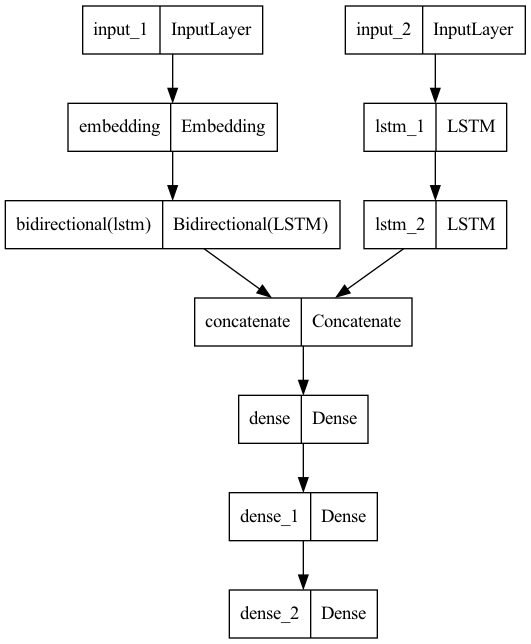

In [26]:
plot_model(model, to_file='model.png')


## Restore the saved model weights


In [27]:
weights_dir = 'model_weights'
latest = tf.train.latest_checkpoint(weights_dir)
if latest != None:
    print("Loading weights from", latest)
    model.load_weights(latest)
else:
    print("Weights not found")
    

Loading weights from model_weights/model_weights_2022-12-19


## Define demo functions

In [28]:
def get_valid_stocks(min_days=2, future=False):
    print('Choose a stock from the following options:')
    valid_stocks = []
    if future:
        stock_list = np.unique(today_news_df['stock'])
    else:
        stock_list = np.unique(list(test_news_df['stock']) + list(today_news_df['stock']))
    for stock in stock_list:
        tmp_df = test_news_df[test_news_df['stock']==stock]
        if len(np.unique(tmp_df['publish_date'])) >= min_days and earliest_date <= min(tmp_df['publish_date']).date() - timedelta(days=N_SEQ_WEEKS * 5):
            valid_stocks.append(stock)
    print('    '.join(valid_stocks))
    return valid_stocks 

def get_date_options(stock_demo_df):
    print("Choose one of the following days ('YYYY-MM-DD') for which you want to predict the stock value:")
    date_options = []
    for day in np.unique(stock_demo_df['prediction_day']):
        option = pd.to_datetime(day).date()
        date_options.append(option)
        print(f'\t{option}')
    if stock_demo_df.loc[0,'stock'] in np.unique(today_news_df['stock']):
        option = date_today + timedelta(days=1)
        print(f'\t{option} (future inference)')
        date_options.append(option)
    return date_options

def check_date(prediction_date):
    try:
        if pd.Timestamp(prediction_date) not in date_options:
            print('Error—-please select a date from the options above')
    except:
        print('Error--ensure your input is a string formatted YYYY-MM-DD and represents a valid date')
    return

def predict_and_display(prediction_date, stock_demo_df):
    # obtain the news for the first prior to the selected data for which at least one article is available
    stock = stock_demo_df.loc[0,'stock']
    if pd.Timestamp(prediction_date) > date_today:
        seq_days = list(close_df[stock].reset_index(drop=False)['Date'])[-(N_SEQ_WEEKS*5):]
        first_date = min(seq_days)
        previous_date = max(seq_days)
        seq = [close_df.loc[day,stock] for day in seq_days]
        seq_mean = np.mean(pd.Series(seq).fillna(0).tolist())
        seq = pd.Series(seq).fillna(seq_mean).tolist()
        assert len(seq) == N_SEQ_WEEKS*5
        
        # build tf dataset
        demo_news = list(today_news_df[today_news_df['stock']==stock]['news'])
        demo_news_vec = vectorize_layer(demo_news).numpy()
        demo_stocks = [seq for n in demo_news]
        demo_targets = [0 for n in demo_news]     # chosen arbitrarily; will be ignored
        
    else:  
        news_demo_df = stock_demo_df[stock_demo_df['prediction_day']==pd.Timestamp(prediction_date)].reset_index(drop=True)
        first_date = news_demo_df.loc[0,'first_day']
        previous_date = news_demo_df.loc[0,'last_day']

        # build tf dataset
        demo_news = list(news_demo_df['news'])
        demo_news_vec = vectorize_layer(demo_news).numpy()
        demo_stocks = list(news_demo_df['stock_seq'])
        demo_targets = list(news_demo_df['target'])
        
    demo_ds = create_ds(demo_news_vec, demo_stocks, demo_targets, N_TIMESTEPS)

    preds = []
    for news_batch, stocks_batch, target_batch in demo_ds:
        for p in model.predict(x=[news_batch, stocks_batch], verbose=0):
            preds.append(p[0])

    # obtain the average prediction
    thresh = 0.5
    avg_pred = np.mean(preds)
    pred = 1
    pred_change = 'increase'
    if avg_pred < 0.5:
        pred = 0
        pred_change = 'decrease'

    print('Prediction:')
    print(f'\t{avg_pred:.2f} --> {pred}')
    print(f'\tStock {stock} will **{pred_change}** from {previous_date.date()} to {prediction_date}')

    if pd.Timestamp(prediction_date) <= date_today:
        true = target_batch.numpy()[0]
        print('\nTrue outcome:')
        true_change = 'increased'
        if true == 0:
            true_change = 'decreased'
        print(f'\t{true}')
        print(f'\tStock {stock} **{true_change}** from {previous_date.date()} to {prediction_date}')

        if pred == true:
            print('\nThe predictions was correct!')
        else:
            print('\nThe prediction was wrong this time.')
    else:
        print(f"\nCheck the stock's close value on {prediction_date} to see if the prediction was right!")
        
    prediction_date = pd.Timestamp(prediction_date)
    plt.figure(figsize=(10,4))

    stock_data_df = close_df[stock][close_df[stock].index < prediction_date]
    plt.plot(stock_data_df, label='sequence data')

    stock_data_df = stock_data_df[stock_data_df.index >= first_date]
    plt.plot(stock_data_df, label='sequence data')

    if pd.Timestamp(prediction_date) <= date_today:
        if pred == true:
            plt.scatter(prediction_date, close_df.loc[prediction_date,stock], color='b', facecolors='none', s=75, alpha=0.7, label='true direction')
            plt.scatter(prediction_date, close_df.loc[prediction_date,stock], color='g', marker='x', label='true direction')
        else:
            plt.scatter(prediction_date, close_df.loc[prediction_date,stock], color='b', facecolors='none', alpha=0.7, label='true direction')
            true_val = close_df.loc[prediction_date,stock]
            previous_val = close_df.loc[previous_date,stock]
            diff = true_val - previous_val
            plt.scatter(prediction_date, previous_val-diff, color='r', marker='x', alpha=0.7, label='pred direction')
    else:
        previous_val = close_df.loc[seq_days[-1], stock]
        before_previous_val = close_df.loc[seq_days[-2], stock]
        diff = previous_val - before_previous_val
        if diff < 0.1:
            diff += 0.25
        if pred == 1:
            plt.scatter(prediction_date, previous_val+np.abs(diff), color='m', marker='x', alpha=0.7, label='pred direction')
        else:
            plt.scatter(prediction_date, previous_val-np.abs(diff), color='m', marker='x', alpha=0.7, label='pred direction')
    
    plt.title(f'Close Value and Prediction for {stock}')
    plt.xlabel('date')
    plt.xticks(rotation=90)
    plt.ylabel('stock close value')

    plt.legend()
    plt.show()
        

## Demo model prediction


A *successful* example:

In [29]:
# prompt user for a stock to focus on
valid_stocks = get_valid_stocks(min_days=4)


Choose a stock from the following options:
AAPL    AJRD    AMD    AMZN    AZN    BA    BAC    C    CMC    COMP    COST    CRM    CVX    DE    DIS    GD    GM    GS    HD    INTC    JNJ    LLY    LMT    MAXR    META    MRNA    MS    MSFT    NFLX    NOC    NVDA    NVS    ORCL    PFE    PG    PYPL    RTX    SBUX    SHOP    TGT    TSLA    UPS    VZ    WMT    XOM    ZEUS    ^GSPC


In [30]:
# user input
stock = 'MSFT'     # choose a stock from the options above
stock_demo_df = test_news_df[test_news_df['stock']==stock].reset_index(drop=True)


In [31]:
# prompt user for a prediction day
date_options = get_date_options(stock_demo_df)


Choose one of the following days ('YYYY-MM-DD') for which you want to predict the stock value:
	2022-12-12
	2022-12-13
	2022-12-15
	2022-12-16
	2022-12-19
	2022-12-20 (future inference)


In [32]:
# user input
prediction_date = '2022-12-13'     # choose a date from the options above
check_date(prediction_date)


Prediction:
	0.91 --> 1
	Stock MSFT will **increase** from 2022-12-12 to 2022-12-13

True outcome:
	1
	Stock MSFT **increased** from 2022-12-12 to 2022-12-13

The predictions was correct!


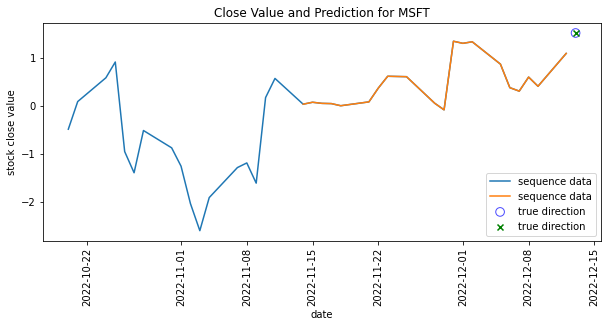

In [33]:
predict_and_display(prediction_date, stock_demo_df)

An *unsuccessful* example:

In [34]:
# prompt user for a stock to focus on
valid_stocks = get_valid_stocks(min_days=4)


Choose a stock from the following options:
AAPL    AJRD    AMD    AMZN    AZN    BA    BAC    C    CMC    COMP    COST    CRM    CVX    DE    DIS    GD    GM    GS    HD    INTC    JNJ    LLY    LMT    MAXR    META    MRNA    MS    MSFT    NFLX    NOC    NVDA    NVS    ORCL    PFE    PG    PYPL    RTX    SBUX    SHOP    TGT    TSLA    UPS    VZ    WMT    XOM    ZEUS    ^GSPC


In [35]:
# user input
stock = 'LLY'     # choose a stock from the options above
stock_demo_df = test_news_df[test_news_df['stock']==stock].reset_index(drop=True)


In [36]:
# prompt user for a prediction day
date_options = get_date_options(stock_demo_df)


Choose one of the following days ('YYYY-MM-DD') for which you want to predict the stock value:
	2022-12-12
	2022-12-14
	2022-12-15
	2022-12-16
	2022-12-19


In [37]:
# user input
prediction_date = '2022-12-19'     # choose a date from the options above
check_date(prediction_date)


Prediction:
	0.89 --> 1
	Stock LLY will **increase** from 2022-12-16 to 2022-12-19

True outcome:
	0
	Stock LLY **decreased** from 2022-12-16 to 2022-12-19

The prediction was wrong this time.


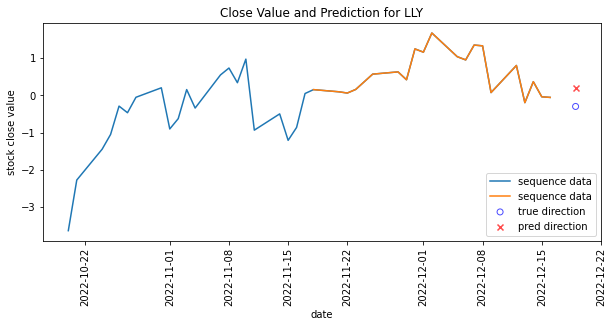

In [38]:
predict_and_display(prediction_date, stock_demo_df)


A *future* example:

In [39]:
# prompt user for a stock to focus on
valid_stocks = get_valid_stocks(min_days=4, future=True)


Choose a stock from the following options:
AAPL    AJRD    AMD    AMZN    AZN    BA    BAC    C    COMP    COST    CRM    CVX    DE    DIS    GD    GM    GS    INTC    LMT    MAXR    META    MS    MSFT    NFLX    NVDA    NVS    ORCL    PG    PYPL    UPS    VZ    XOM    ZEUS    ^GSPC


In [40]:
# user input
stock = 'UPS'     # choose a stock from the options above
stock_demo_df = test_news_df[test_news_df['stock']==stock].reset_index(drop=True)


In [41]:
# prompt user for a prediction day
date_options = get_date_options(stock_demo_df)


Choose one of the following days ('YYYY-MM-DD') for which you want to predict the stock value:
	2022-12-12
	2022-12-15
	2022-12-16
	2022-12-19
	2022-12-20 (future inference)


In [42]:
# user input
prediction_date = '2022-12-20'     # choose a date from the options above
check_date(prediction_date)


Prediction:
	0.00 --> 0
	Stock UPS will **decrease** from 2022-12-19 to 2022-12-20

Check the stock's close value on 2022-12-20 to see if the prediction was right!


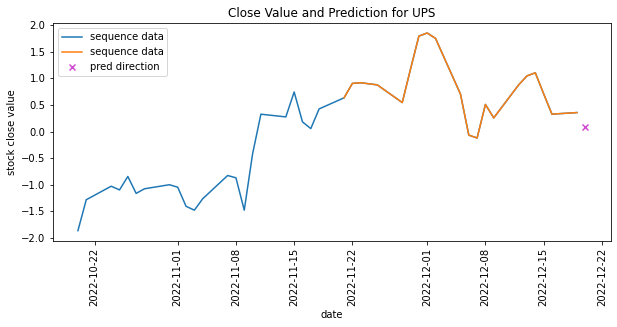

In [43]:
predict_and_display(prediction_date, stock_demo_df)
